# TP 2-3 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [3]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


### Récupération des données

In [4]:
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [5]:
function TestsSondabilite_LP(capacity, poids, bornesup, BestProfit)
    TA, TO, TR = false, false, false
    bool = true
    if (capacity<0)#Test de faisabilite
        TA=true
        println("TA")
    elseif (bornesup <= BestProfit) #Test d'optimalite
        TO=true
        println("TO")
    else
        #Test de resolution
        if ( capacity == 0)
            TR=true
            println("TR")
        else 
            for i in 1:length(poids)
                if (capacity > poids[i])
                    bool = bool && false
                end
            TR = bool
            end
        end

        if (TR = false)
            println("non sondable")
        end
    end
    TA, TO, TR
end

TestsSondabilite_LP (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [6]:

function SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, n)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node at the left  
    
    # lexicographic branching criterion: branch on the 1st object not yet fixed
    i, obj = 1, 0
    while((i <= n) && (obj==0))
        if(!(i in listobjs))
            obj=i
        end
        i+=1
    end
    
    println("\nbranch on object ", obj, "\n")

    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listobjs,obj) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
end


function ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible
    
    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
        end
        if theval==1.0
            push!(listobjs,obj)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    return stop 
end

ExplorerAutreNoeud_depthfirst! (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): <span style="color:red"> SECTION A SUPPRIMER !!!! </span>

<span style="color:red"> Cette section est à commenter/supprimer et remplacer par vos propres calculs de bornes supérieures et autres, par exemple basées sur les bornes 1 et 2 vues en cours, ou d'autres calculs de bornes de votre choix/conception validés au préalable par votre encadrant/e de TP </span>

In [7]:
function calBorne(cout, poids, capacite, val_charge, option)

    # Borne 1
    r = cout./poids
    if option == 1
        borne = capacite * maximum(r; init =0)

    # Borne 2
    elseif option == 2
        borne = 0
        #trier les objets par ri
        if length(cout) > 0
            l = []
            for i in 1:length(cout)
                l = [l;(r[i],poids[i])]
            end
        
            sort!(l, by = x -> x[1], rev=true)
            
            # remplir le sac à dos en mettant d'abord entièrement les objets avec le meilleur ri puis ajouter 
            # la fraction du dernier objet
            for i in 1:length(l)
                while (capacite - l[i][2]) > 0
                    borne = borne + l[i][1]*l[i][2]
                    capacite = capacite - l[i][2]
                end
            end
            
        end
    end
    return (val_charge + borne)
end

calBorne (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [8]:

function SolveKnapInstance(filename)

    price, weight, capacity = readKnaptxtInstance(filename)
    n = length(price)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=[]
    listvals=[]
    listnodes=[]

    BestProfit = -1
    Bestsol=[]

    current_node_number=0
    stop = false

    while(!stop)

        println("\nNode number ", current_node_number, ": \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if (length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)

        # Maj de price_courant, weight_courant, capacity_courant
        price_courant = deepcopy(price)
        weight_courant = deepcopy(weight)
        capacity_courant = capacity
        
        val_charge = 0
        for i in 1:length(listobjs)
            obj = listobjs[i]
            if listvals[i] == 1
                capacity_courant = capacity_courant - weight[obj]
                # Garder ka valeur des objets dans le sac avant le calcul de la borne
                val_charge = val_charge + price[obj]
            end
        end
        deleteat!(price_courant, listobjs)
        deleteat!(weight_courant, listobjs)

        # Maj de Bestsol et BestProfit
        if capacity_courant >= 0
            if val_charge > BestProfit
                BestProfit = val_charge
                Bestsol = zeros(n)
                for i in 1:length(listobjs)
                    obj = listobjs[i]
                    if listvals[i] == 1
                        Bestsol[obj] = 1
                    end
                end
            end
        end
        
        println("Bestsol : "*string(Bestsol))
        println("BestProfit : "*string(BestProfit))
        println("Capacite : "*string(capacity_courant))

        # Calcul de la borne sup
        option = 2
        bornesup = calBorne(price_courant, weight_courant, capacity_courant, val_charge, option)
        
        # Test de sondabilité
        TA, TO, TR = TestsSondabilite_LP(capacity_courant, weight_courant, bornesup, BestProfit)
        is_node_sondable = TA || TO || TR

        #Reset_LP!(model2, x, listobjs)

        if (!is_node_sondable)
            SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, length(price))
        else
            stop = ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes)
        end
        

        current_node_number = current_node_number + 1
    end

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


SolveKnapInstance (generic function with 1 method)

### Affichage du résultat final

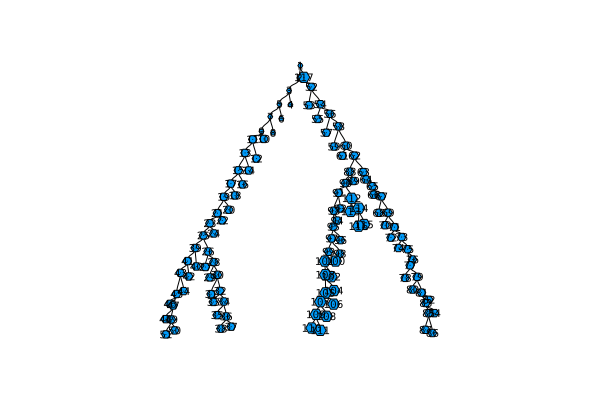

In [15]:
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/weakly_correlated_span/knapPI_12_20_1000_1_-970.opb.txt")
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)

## Questions préliminaires:
1. Quelle est la règle de séparation ? \
   La règle de séparation est celle par ordre lexicographique. On choisit le premier objet dans la liste qui n'a pas été encore pris.

2. Quelle est la méthode de calcul de borne supérieure ? \
   La méthode de calcul de borne supérieure correspond à la solution de la relaxation linéaire en fixant la valeur des objets pris à 1(et celle de objets non pris à 0).

3. Quels sont les tests de sondabilité TA, TO, TR?
   Test de sondabilité: 
   * TA : Le test d'admissibilité passe si la relaxation linéaire admet une solution.
   * TO : La solution de la relaxation linéaire est inférieur au profit maximal.
   * TR : La solution de relaxation linéaire est atteinte par des valeurs entières.

   
4. Quelle est la stratégie d’exploration ? \
   La stratégie d'exploration est la stratégie depthfirst, exploration en profondeur.

## Code et analyse

1. cf code

2. cf code

3. Points clés de  notre implémentation des différents blocs du Branch-and-Bound:

    * `règle de séparation` : nous avons gardé l'ordre lexicographique défini initialement.
    * `TA` : Le test de faisabilité passe si la capacité du sac à dos est négative: en effet le sac à dos déborde et la situation n'est plus valide.
    * `TO` : Le test d'optimalité passe si la valeur de la borne supérieur, obtenue en remplissant le sac à dos, est inférieure à la meilleure solution déjà trouvée pour le sac à dos. En effet dans ce cas, il n'existe aucune combinaison d'objets permettant d'obtenir une meilleure valeur pour le sac final.
    * `TR` : Le test de relaxation passe si nous trouvons une solution évidente au problème. Nous avons choisi de le valider si la capacité du sac à dos est nulle au noeud sondé (ie nous ne pouvons ajouter aucun autre objet dans cette situation, donc nous avons une solution évidente).
    * `Stratégie d'exploration` : nous avons gardé la stratégie deephtfirst (d'exploration en profondeur) définie initialement.
    

4. Pour la structure de données permettant de garder les informations nécessaires au Branch-and-Bound, nous avons choisi de garder la structure définie intialement à l'aide de `listvals`, `listobj`et `listnodes`, ainsi que `BestProfit` et `Bestsol`. Nous avons décidé de mettre à jour ces derniers dans le programme principal à chaque noeud où la capacité est valide. Enfin, nous avons crée `weight_courant`, `price_courant` et `capacity_courant` pour avoir à chaque itération des valeurs actualisées de respectivement `weight`, `price` et `capacity`, qui sont utilisés notamment pour le calcul de la bornesup et déterminer si une nouvelle solution optimale est atteinte.

5. Le résultat du Branch-and-Borne en utilisant quelle que soit la borne, ce qui semble cohérent (d'après le TD). Cependant, selon les bornes, les performances diffèrent. En effet, on remarque que la borne 2 a tendance à être plus petite que la borne 1. Par conséquent, le test d'optimalité a plus tendance à être vrai pour la borne 2 que la borne 1. Ainsi, il y a moins de sépération de noeuds et donc un nombre total de noeuds inférieur en utilisant la borne 2 que la borne 1. 
